In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np


import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,roc_curve,roc_auc_score
from sklearn.preprocessing import OrdinalEncoder


In [2]:
#1. Carga el dataset del Titanic. 

df = pd.read_csv('./titanic.csv')
df.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [4]:

def get_features_cat_regression(df, target_col, pvalue=0.05, cardinality_threshold=0.1):
    # Verificar si df es un DataFrame de pandas
    if not isinstance(df, pd.DataFrame):
        return None

    # Verificar si target_col es una columna del DataFrame
    if target_col not in df.columns:
        return None

    # Verificar si target_col es numérica
    if not pd.api.types.is_numeric_dtype(df[target_col]):
        return None

    # Calcular el umbral de cardinalidad basado en la proporción
    cardinality_limit = int(cardinality_threshold * df[target_col].nunique())

    # Verificar la cardinalidad de target_col
    if df[target_col].nunique() < cardinality_limit:
        return None

    # Identificar columnas categóricas
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns

    # Lista para guardar las columnas que pasan el test
    significant_cols = []

    # Calcular la media de la columna objetivo
    overall_mean = df[target_col].mean()

    # Realizar test para cada columna categórica
    for col in categorical_cols:
        unique_values = df[col].nunique()

        if unique_values > 1 and unique_values <= cardinality_limit:  # T-Test para baja cardinalidad
            for unique_value in df[col].unique():
                group = df[df[col] == unique_value][target_col]
                t_stat, p_val = stats.ttest_1samp(group, overall_mean, nan_policy='omit')
                if p_val < pvalue:
                    significant_cols.append(col)
                    break

        elif unique_values > cardinality_limit:  # Z-Test para alta cardinalidad
            for unique_value in df[col].unique():
                subgroup = df[df[col] == unique_value][target_col]
                
                # Definir éxito como estar por encima de la media general
                success_count = np.sum(subgroup > overall_mean)
                nobs = len(subgroup)

                # Calcular Z-Test
                z_stat, p_val = proportions_ztest(success_count, nobs, prop=0.5)

                if p_val < pvalue:
                    significant_cols.append(col)
                    break

    return significant_cols





In [5]:


def get_features_cat_regression_pintando(df, target_col, pvalue=0.05, cardinality_threshold=0.1):
    # Verificar si df es un DataFrame de pandas
    if not isinstance(df, pd.DataFrame):
        print("El argumento df debe ser un DataFrame de pandas.")
        return None

    # Verificar si target_col es una columna del DataFrame
    if target_col not in df.columns:
        print(f"La columna '{target_col}' no existe en el DataFrame.")
        return None

    # Verificar si target_col es numérica
    if not pd.api.types.is_numeric_dtype(df[target_col]):
        print(f"La columna '{target_col}' debe ser numérica.")
        return None

    # Calcular el umbral de cardinalidad basado en la proporción
    cardinality_limit = int(cardinality_threshold * df[target_col].nunique())
    print(f"Umbral de cardinalidad calculado: {cardinality_limit}")

    # Verificar la cardinalidad de target_col
    if df[target_col].nunique() < cardinality_limit:
        print(f"La columna '{target_col}' no tiene suficiente cardinalidad (umbral: {cardinality_limit} valores únicos).")
        return None

    # Identificar columnas categóricas
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    print(f"Columnas categóricas identificadas: {list(categorical_cols)}")

    # Lista para guardar las columnas que pasan el test
    significant_cols = []

    # Calcular la media de la columna objetivo
    overall_mean = df[target_col].mean()
    print(f"Media general de '{target_col}': {overall_mean}")

    # Realizar test para cada columna categórica
    for col in categorical_cols:
        unique_values = df[col].nunique()

        if unique_values > 1 and unique_values <= cardinality_limit:  # T-Test para baja cardinalidad
            print(f"Realizando T-Test en la columna '{col}'")
            for unique_value in df[col].unique():
                group = df[df[col] == unique_value][target_col]
                t_stat, p_val = stats.ttest_1samp(group, overall_mean, nan_policy='omit')
                if p_val < pvalue:
                    print(f"Columna '{col}': T-Test realizado, p-value = {p_val:.4f}, variable aceptada.")
                    significant_cols.append(col)
                    break
                else:
                    print(f"Columna '{col}': T-Test realizado, p-value = {p_val:.4f}, variable no aceptada.")

        elif unique_values > cardinality_limit:  # Z-Test para alta cardinalidad
            print(f"Realizando Z-Test en la columna '{col}'")
            for unique_value in df[col].unique():
                subgroup = df[df[col] == unique_value][target_col]
                
                # Definir éxito como estar por encima de la media general
                success_count = np.sum(subgroup > overall_mean)
                nobs = len(subgroup)

                # Calcular Z-Test
                z_stat, p_val = proportions_ztest(success_count, nobs, prop=0.5)

                if p_val < pvalue:
                    print(f"Columna '{col}': Z-Test realizado, p-value = {p_val:.4f}, variable aceptada.")
                    significant_cols.append(col)
                    break
                else:
                    print(f"Columna '{col}': Z-Test realizado, p-value = {p_val:.4f}, variable no aceptada.")

    return significant_cols




In [6]:
get_features_cat_regression_pintando(df,"age")

Umbral de cardinalidad calculado: 8
Columnas categóricas identificadas: ['sex', 'embarked', 'class', 'who', 'deck', 'embark_town', 'alive']
Media general de 'age': 29.69911764705882
Realizando T-Test en la columna 'sex'
Columna 'sex': T-Test realizado, p-value = 0.1369, variable no aceptada.
Columna 'sex': T-Test realizado, p-value = 0.0422, variable aceptada.
Realizando T-Test en la columna 'embarked'
Columna 'embarked': T-Test realizado, p-value = 0.6730, variable no aceptada.
Columna 'embarked': T-Test realizado, p-value = 0.4114, variable no aceptada.
Columna 'embarked': T-Test realizado, p-value = 0.6186, variable no aceptada.
Columna 'embarked': T-Test realizado, p-value = nan, variable no aceptada.
Realizando T-Test en la columna 'class'
Columna 'class': T-Test realizado, p-value = 0.0000, variable aceptada.
Realizando T-Test en la columna 'who'
Columna 'who': T-Test realizado, p-value = 0.0000, variable aceptada.
Realizando T-Test en la columna 'deck'
Columna 'deck': T-Test rea

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


['sex', 'class', 'who', 'deck']

In [7]:
get_features_cat_regression(df,"age")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


['sex', 'class', 'who', 'deck']

In [8]:

def plot_features_cat_regression(df, target_col="", columns=[], pvalue=0.05, with_individual_plot=False):
    # Verificaciones iniciales
    if not isinstance(df, pd.DataFrame):
        print("El argumento df debe ser un DataFrame de pandas.")
        return None
    if target_col not in df.columns:
        print("La columna target_col no está en el DataFrame.")
        return None
    if not pd.api.types.is_numeric_dtype(df[target_col]):
        print("La columna target_col debe ser numérica.")
        return None

    # Si columns está vacío, usar todas las variables categóricas
    if not columns:
        columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Lista para almacenar columnas significativas
    significant_cols = []

    # Revisar cada columna categórica
    for col in columns:
        if df[col].nunique() > 1:  # Ignorar columnas con un solo valor
            # Calcular el p-value para la relación entre la variable categórica y target_col
            groups = [group[target_col].dropna() for name, group in df.groupby(col)]
            f_stat, p_val = stats.f_oneway(*groups)
            
            # Chequear si la relación es significativa
            if p_val < pvalue:
                significant_cols.append(col)
                
                # Generar histograma si with_individual_plot es True
                if with_individual_plot:
                    df.groupby(col)[target_col].plot(kind='hist', alpha=0.5, legend=True)
                    plt.title(f"Histograma de '{target_col}' agrupado por '{col}'")
                    plt.show()

    return significant_cols

# Ejemplo de uso
# df = pd.read_csv('tu_archivo.csv')
# significant_columns = plot_features_cat_regression(df, 'tu_columna_objetivo', with_individual_plot=True)
# print(significant_columns)


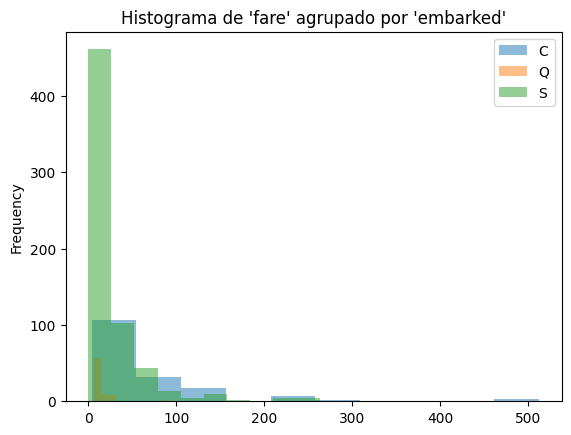

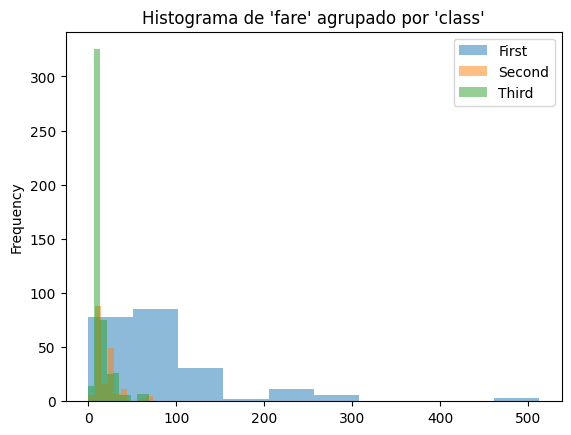

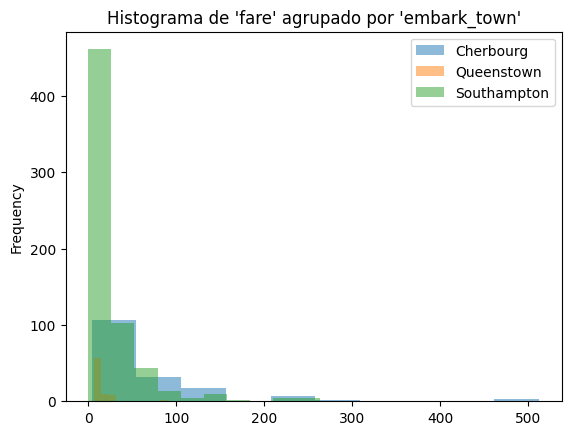

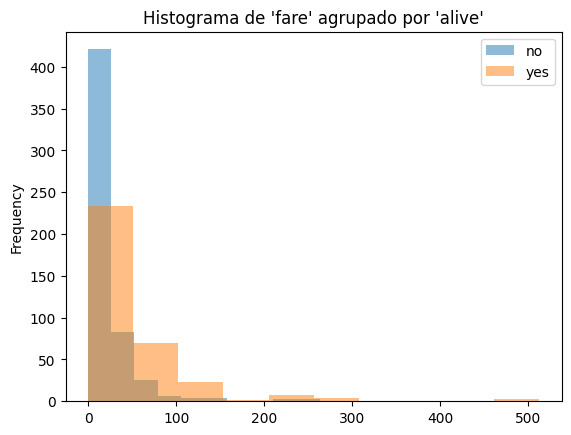

['embarked', 'class', 'embark_town', 'alive']

In [9]:
plot_features_cat_regression(df,"fare",pvalue=0.00000000000001,with_individual_plot=True)